<a href="https://colab.research.google.com/github/MLGroup28/financial_text_sentiment_analysis/blob/main/financial_text_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
    Machine learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2025<br>
<font color=3C99D size=5>
      Financial Text Sentiment Analysis
</div>
<div dir=ltr align=center>
<font color=0CBCDF size=4>
    Faraz Doagooye Tehrani, Amir Parsa Safari, Hosna Shahheidari
<br>
<font color=0CBCDF size=4>
</div>

____

# PART ONE

---

In [42]:
from google.colab import drive
import zipfile
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import math
from transformers import BertTokenizer

In [43]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
zip_path = '/content/drive/MyDrive/data/FinancialPhraseBank-v1.0.zip'
extract_path = '/content/financial_data/FinancialPhraseBank-v1.0/'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Files extracted successfully!")

data_file_allagree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_AllAgree.txt'
df_allagree = pd.read_csv(data_file_allagree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')

print(f"Data ready! Total rows of all agree: {len(df_allagree)}")
df_allagree.head()

Data ready! Total rows of all agree: 2264


,sentence,label
0,"According to Gran , the company has no plans t...",neutral
1,"For the last quarter of 2010 , Componenta 's n...",positive
2,"In the third quarter of 2010 , net sales incre...",positive
3,Operating profit rose to EUR 13.1 mn from EUR ...,positive
4,"Operating profit totalled EUR 21.1 mn , up fro...",positive


In [45]:
data_file_75agree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_75Agree.txt'
df_75agree = pd.read_csv(data_file_75agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_66agree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_66Agree.txt'
df_66agree = pd.read_csv(data_file_66agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')
data_file_50agree = extract_path + 'FinancialPhraseBank-v1.0/Sentences_50Agree.txt'
df_50agree = pd.read_csv(data_file_50agree, sep='@', names=['sentence', 'label'], encoding='ISO-8859-1')


set_all = set(df_allagree['sentence'])
set_75 = set(df_75agree['sentence'])
set_66 = set(df_66agree['sentence'])
set_50 = set(df_50agree['sentence'])

check_1 = set_all.issubset(set_75)
check_2 = set_75.issubset(set_66)
check_3 = set_66.issubset(set_50)

print(f"Is AllAgree inside 75Agree? {check_1}")
print(f"Is 75Agree inside 66Agree? {check_2}")
print(f"Is 66Agree inside 50Agree? {check_3}")

print(f"\nCounts:")
print(f"AllAgree: {len(set_all)}")
print(f"75Agree:  {len(set_75)}")
print(f"66Agree:  {len(set_66)}")
print(f"50Agree:  {len(set_50)}")

Is AllAgree inside 75Agree? True
Is 75Agree inside 66Agree? True
Is 66Agree inside 50Agree? True

Counts:
AllAgree: 2259
75Agree:  3448
66Agree:  4211
50Agree:  4838


In [46]:
df_final = df_50agree.copy()

def assign_weight(sentence):
    if sentence in set_all:
        return 1.0
    elif sentence in set_75:
        return 0.75
    elif sentence in set_66:
        return 0.66
    else:
        return 0.50

df_final['weight'] = df_final['sentence'].apply(assign_weight)

print(df_final['weight'].value_counts())

weight
1.00    2264
0.75    1190
0.66     765
0.50     627
Name: count, dtype: int64


<font color=3C99D size=5>
Conclusion: </font>

Since the set of 50 agree is the most general one we will train on that

In [47]:
df = df_final

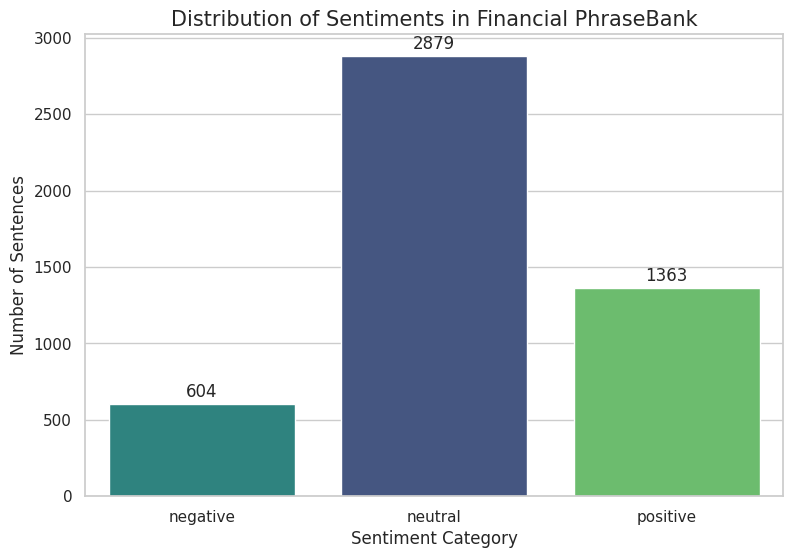

In [48]:
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

ax = sns.countplot(x='label', data=df, palette='viridis', order=['negative', 'neutral', 'positive'], hue='label', legend=False)

plt.title('Distribution of Sentiments in Financial PhraseBank', fontsize=15)
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Number of Sentences', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points')

plt.show()

In [49]:
label_encoder = LabelEncoder() #turning labels to numbers
df['label_idx'] = label_encoder.fit_transform(df['label'])

class_names = label_encoder.classes_
print(f"Mapping: {dict(zip(range(len(class_names)), class_names))}")

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label_idx']
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

Mapping: {0: 'negative', 1: 'neutral', 2: 'positive'}
Train size: 3876, Validation size: 970


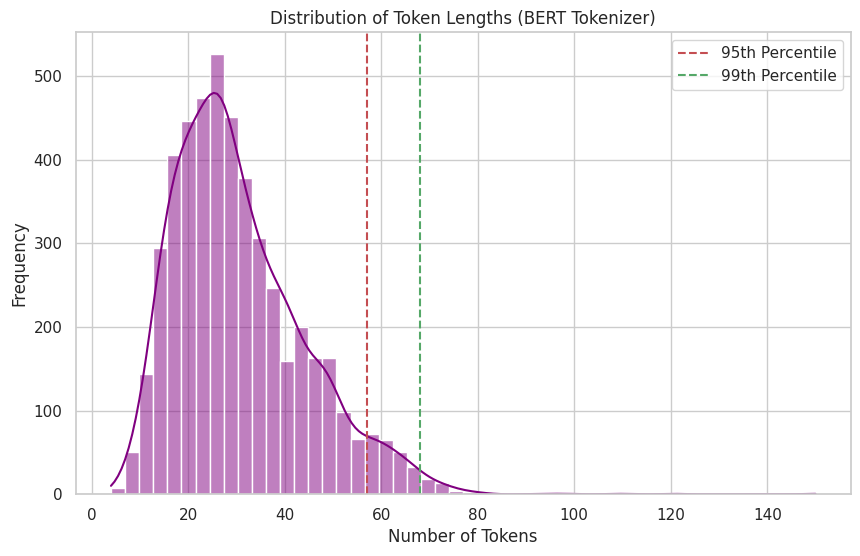

95% Percentile: 57.0
99% Percentile: 68.0
Max Length: 150


In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df['token_lengths'] = [len(tokenizer.encode(s, add_special_tokens=True)) for s in df['sentence']]

plt.figure(figsize=(10, 6))
sns.histplot(df['token_lengths'], bins=50, kde=True, color='purple')
plt.title('Distribution of Token Lengths (BERT Tokenizer)')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')

plt.axvline(x=df['token_lengths'].quantile(0.95), color='r', linestyle='--', label='95th Percentile')
plt.axvline(x=df['token_lengths'].quantile(0.99), color='g', linestyle='--', label='99th Percentile')
plt.legend()
plt.show()

print(f"95% Percentile: {df['token_lengths'].quantile(0.95)}")
print(f"99% Percentile: {df['token_lengths'].quantile(0.99)}")
print(f"Max Length: {df['token_lengths'].max()}")

<font color=3C99D size=5>
Conclusion: </font>

Since only less than one percent of the sentences have more than 68 tokens, choosing 80 tokens as the max length is a good number



In [51]:
class FinancialDataset(Dataset):
    def __init__(self, sentences, labels, weights, tokenizer, max_len=80):
        self.sentences = sentences.values
        self.labels = labels.values
        self.weights = weights.values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, item):
        sentence = str(self.sentences[item])
        label = self.labels[item]
        weight = self.weights[item]

        encoding = self.tokenizer(
            sentence,
            add_special_tokens=True,  #Added [CLS], [SEP]
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long),
            'weights': torch.tensor(weight, dtype=torch.float)
        }

In [52]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_dataset = FinancialDataset(train_df['sentence'], train_df['label_idx'], train_df['weight'], tokenizer)
val_dataset = FinancialDataset(val_df['sentence'], val_df['label_idx'], val_df['weight'], tokenizer)

BATCH_SIZE = 16 #todo change to see the different results

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

sample_batch = next(iter(train_loader))
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention Mask shape: {sample_batch['attention_mask'].shape}")

Input IDs shape: torch.Size([16, 80])
Attention Mask shape: torch.Size([16, 80])


# PART TWO

---

In [53]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)

        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, q, k, v, mask=None):
        batch_size = q.size(0)

        Q = self.W_q(q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(k).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(v).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attn_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attn_weights, V)

        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)

        return self.W_o(output)

In [54]:
class TransformerBlock(nn.Module):#Encoder only, as we need the whole thing for sentiment analysis and we don't need the masked multihead attention in decoder.
    def __init__(self, d_model, num_heads, ff_hidden_dim, dropout=0.1): #ff_hidden_dim can be increased in the case of underfitting
    # and decreased in the case of overfitting #todo ff_hidden_dim hyperparameter
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, ff_hidden_dim),
            nn.ReLU(),
            nn.Linear(ff_hidden_dim, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention.forward(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))

        return x

In [55]:
class FinancialTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, ff_hidden_dim, max_len, num_classes=3):
        super(FinancialTransformer, self).__init__()

        #these are learnable embeddings
        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, ff_hidden_dim)
            for _ in range(num_layers)
        ])

        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, input_ids, attention_mask):
        batch_size, seq_len = input_ids.shape

        #creating a list of numbers for each position and expanding it to every sentence and putting it on the same device as input_ids so we won't get an error.
        positions = torch.arange(0, seq_len).expand(batch_size, seq_len).to(input_ids.device)

        x = self.token_embedding(input_ids) + self.position_embedding(positions)
        x = self.dropout(x)

        mask = attention_mask.unsqueeze(1).unsqueeze(2)

        #Passing through all the encoder layers.
        for layer in self.layers:
            x = layer(x, mask)


        #The classifier expects a 2D tensor. So we only use the value for [CLS] which is the first token of every sentence as a summary for all the tokens of the sentence.
        cls_output = x[:, 0, :]

        #We are just using a linear mapping on the outputs and not a softmax. Later when we use nn.CrossEntropyLoss the softmax will be applied.
        #That is computationaly better as we won't have to deal with big or small numbers with some tricks.
        return self.fc(cls_output)

In [56]:
VOCAB_SIZE = tokenizer.vocab_size
D_MODEL = 512      #Hyperparameter  -> must be divisible by NUM_HEADS
NUM_HEADS = 8      #Hyperparameter
NUM_LAYERS = 4      #Hyperparameter
FF_HIDDEN_DIM = 2048  #Hyperparameter
MAX_LEN = 80          #Don't put it less than 68 and make it divisible by 8
NUM_CLASSES = 3

model = FinancialTransformer(
    vocab_size=VOCAB_SIZE,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    ff_hidden_dim=FF_HIDDEN_DIM,
    max_len=MAX_LEN,
    num_classes=NUM_CLASSES
)

print(model)

FinancialTransformer(
  (token_embedding): Embedding(30522, 512)
  (position_embedding): Embedding(80, 512)
  (layers): ModuleList(
    (0-3): 4 x TransformerBlock(
      (attention): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (ffn): Sequential(
        (0): Linear(in_features=512, out_features=2048, bias=True)
        (1): ReLU()
        (2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)


# PART THREE

---

In [57]:
criterion = nn.CrossEntropyLoss(reduction='none') #By setting reduction to none we are telling it not to give us the mean of the losses of the batches
#We want the loss for each one so we can multiply it by its corresponding weight.
optimizer = optim.Adam(model.parameters(), lr=1e-5)

<font color=DC143C size=6>
Warning </font>

Only set the train boolean in the cell below to True if you want to train and else set it to False.

In [58]:
train = True

In [ ]:
def train_model(model, train_loader, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_history = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            conf_weights = batch['weights'].to(device)

            #Each batch should be handled seperatly so we reset it for each of them.
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)

            losses = criterion(outputs, labels)
            loss = torch.mean(losses * conf_weights)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            total_correct += (preds == labels).sum().item() #We don't include the weights here as it makes it harder to explain

        avg_loss = total_loss / len(train_loader)
        avg_acc = total_correct.double() / len(train_loader.dataset)

        train_history['loss'].append(avg_loss)
        train_history['acc'].append(avg_acc.item())

        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}')

    return train_history
epochs = 5 #Hyperparameter
if train:
  history = train_model(model, train_loader, epochs)

  path = '/content/drive/MyDrive/data/checkpoint.pth'
  checkpoint = {
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'history': history,
      'epoch': epochs
  }
  torch.save(checkpoint, path)


In [ ]:

if not train:
  path = '/content/drive/MyDrive/data/checkpoint.pth'
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  if os.path.exists(path):
      checkpoint = torch.load(path, map_location=device)

      model.load_state_dict(checkpoint['model_state_dict'])

      optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

      history = checkpoint['history']

      model.to(device)
      print(f"Successfully loaded checkpoint from epoch {checkpoint['epoch']}")
  else:
      print("No checkpoint found. You need to train the model first.")
      history = train_model(model, train_loader, epochs)

      path = '/content/drive/MyDrive/data/checkpoint.pth'
      checkpoint = {
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'history': history,
          'epoch': epochs
      }
      torch.save(checkpoint, path)

In [ ]:
def evaluate_model(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval() # Sets layers like Dropout to off

    val_loss, val_correct = 0, 0

    with torch.no_grad(): # Stops memory use for gradients
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, dim=1)
            val_correct += torch.sum(preds == labels)

    avg_loss = val_loss / len(data_loader)
    avg_acc = val_correct.double() / len(data_loader.dataset)

    print(f'Evaluation -> Loss: {avg_loss:.4f} | Accuracy: {avg_acc:.4f}')
    return avg_loss, avg_acc

val_loss, val_acc = evaluate_model(model, val_loader)

In [ ]:
def plot_results(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_results(history)